# 3. Logistic Regression Model for National Gas Price Trend

### Table of Contents
* Set-up
* Binary Classification Problem
* Features
* Logistic Regression Path
* l2 Regularization Parameter
* Test in Cross-Validation Period
  + Prediction
  + Recall
  + Accuracy
* Comparison to Multivariate Rolling Regression and ARIMA

## Set-up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import logistic_regression_path, LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.svm import l1_min_c
%matplotlib inline

/Users/ChingYunH/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def custom_read_csv(filename):
    df = pd.read_csv(filename)
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index('date')

Read retail gas prices from csv.

In [3]:
# note that all prices are released on Monday, dayofweek = 0
national_price = custom_read_csv('national.csv').dropna()
state_price = custom_read_csv('state.csv').dropna()
state_price = state_price.drop('Unnamed: 10', axis=1).dropna()
city_price = custom_read_csv('city.csv').dropna()
price = pd.concat([national_price, state_price, city_price], axis=1)

The training period is 1992 - 2010. Save 2011 - 2016 for cross-validation.

In [4]:
trainingdates = np.intersect1d(price.index, pd.date_range('1992-01-01','2010-12-31'))

## Binary Classification Problem

Instead of predicting the retail gas price, consumers are more interested in the directional move.

Predicting the directional move can help consumers decide when to fill their gas tanks. The exact value of price change is perhaps not as important, since consumers are unlikely to make a profit from trading retail gas.

Therefore, we can frame the problem as binary classification - whether the price goes up or down.

In [5]:
up = ((price.national - price.national.shift(1))).dropna() > 0

In this binary classification problem, we don't expect to predict a clear distinction between up and down moves, due to the noise in data. Therefore, logistic regression is a better choice than SVM.

## Features

We include previously selected predictors from the multivariate regression model and the ARIMA model.

The features are **log returns** of the following time series:

* Gulf Coast gasoline spot price
* Gasoline stocks
* Retail gas price lagged by 1,2,3 weeks

All features are weekly time series.

In [6]:
gasspot = custom_read_csv('gasspot.csv').drop('Unnamed: 3', axis=1).dropna()
stocks = custom_read_csv('stocks.csv').dropna()
predictors_raw = pd.concat([gasspot.gas_spot_gulf, stocks.stocks_gasoline], axis=1)

# the predictors are relaesed on Friday, add 3 days to align
predictors_raw.index = predictors_raw.index + pd.DateOffset(days=3)

# include the lagged series by 1,2,3 weeks to capture autocorrelation
predictors_raw = pd.concat([predictors_raw] + \
                           [price.national.shift(i).rename('retail gas lag %d week'%i) for i in range(1,4)], 
                           axis=1)

# take log return for all predictors
predictors = (predictors_raw - predictors_raw.shift(1)) / predictors_raw.shift(1)

## Logistic Regression Path

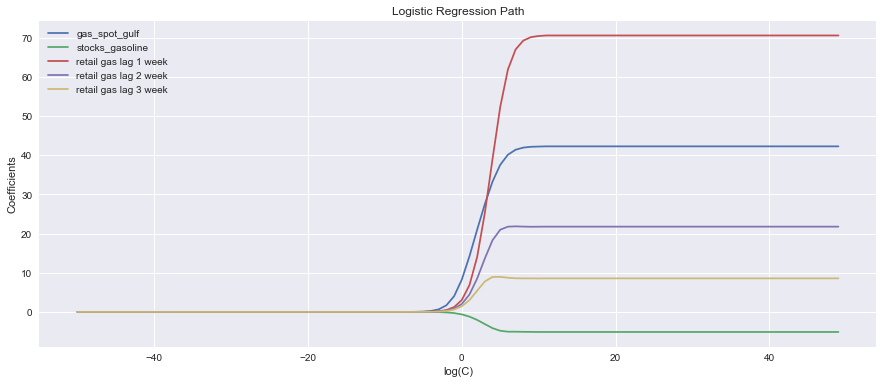

In [7]:
y1 = up.loc[trainingdates].values
X1 = predictors.loc[trainingdates].values
cs = np.exp(np.arange(-50,50,1))
coefs, Cs, _ = logistic_regression_path(X1, y1, Cs=cs)

plt.figure(figsize=(15,6))
plt.plot(np.log(Cs), [x[:-1] for x in coefs])
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.legend(predictors.columns)
plt.show()

##  l2 Regularization Parameter

Search for the best l2 regularization coefficient.

Devide the training set into two halves randomly. 

For each candidate regularization parameter, 
* fit logistic regression model to the first half of training set
* record the prediction accuracy on the second half of the training set 

Pick the regularization parameter with highest accuracy.

In [8]:
training1 = trainingdates[np.random.permutation(len(trainingdates))[:len(trainingdates)/2]]
training2 = trainingdates[np.random.permutation(len(trainingdates))[len(trainingdates)/2:]]

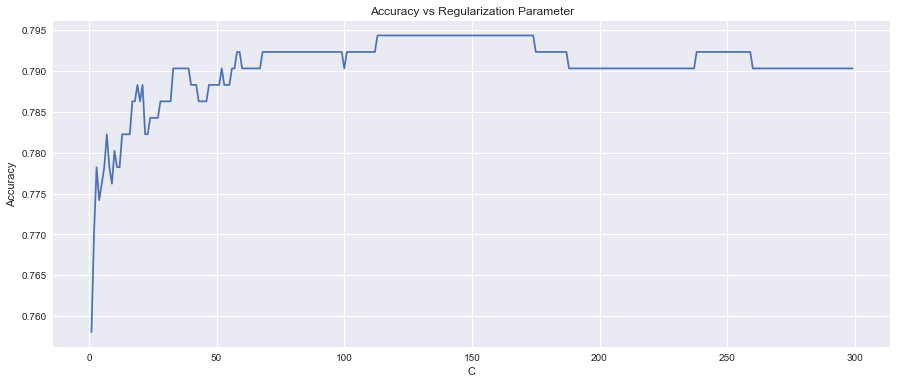

Regularization parameter with highest accuracy: 113


In [9]:
y1 = up.loc[training1].values
X1 = predictors.loc[training1].values
y2 = up.loc[training2].values
X2 = predictors.loc[training2].values

Cs = np.arange(1,300)
score = np.zeros(len(Cs))
for i, C in enumerate(Cs):
    model = LogisticRegression(C=C).fit(X1, y1)
    score[i] = model.score(X2, y2)
    
plt.figure(figsize=(15,6))
plt.plot(Cs, score)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Regularization Parameter')
plt.show()

print 'Regularization parameter with highest accuracy: %.0f' % Cs[np.argmax(score)]

According to the above result, choose **81** as the regularization parameter for logistics regression

## Test in Cross-Validation Period

### Metric: Precision and Recall of Predicted Price Move Directions

In [10]:
cvdates = np.intersect1d(price.index, pd.date_range('2011-01-01','2016-12-31'))

In [11]:
y_training = up.loc[trainingdates].values
X_training = predictors.loc[trainingdates].values
model = LogisticRegression(C=81).fit(X_training, y_training)

y_cv = up.loc[cvdates].values
X_cv = predictors.loc[cvdates].values
prediction = model.predict(X_cv)

#### Precision

In [12]:
1.0 * np.logical_and(y_cv, prediction).sum() / prediction.sum()

0.9083333333333333

#### Recall

In [13]:
1.0 * np.logical_and(y_cv, prediction).sum() / y_cv.sum()

0.7730496453900709

#### Accuracy

In [14]:
1.0 * (y_cv == prediction).sum() / len(prediction)

0.8626198083067093

## Comparison to Multivariate Rolling Regression and ARIMA

* Performance in Cross-Validation 

| Model                            | Precision   | Recall     | Accuracy  |
| -------------                    |:-----------:|:----------:|:---------:|
| Multivariate Rolling Regression  | 66%         |   78%      | 72%       |
| ARIMA                            | 68%         |   71%      | 72%       |
| Logistic Regression              | 91%         |   77%      | 86%       |

Logistic regression has significantly higher precision, recall, and accuracy. For classifying up/down price moves, logistic regression is the best model.